# Premier League Player Analysis

For this project, I decided to combine two things I love, data and soccer (or as some call it the real football). I wanted to put myself in the shoes of one of the smaller clubs in the Premier League and imagine I need to sign a new defensive midfielder for my team, as one of my star defensive midfielders left the club. Data can provide impactful insights as to who would be an appropriate signing for the team. 


## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Overview

The dataset is ready to be loaded, as it is in a CSV file created by the scraper script. We can load it use it pandas and visualize a few rows of data.

In [2]:
df = pd.read_csv('data/notebook/Prem_player_stats.csv', index_col=0)

In [3]:
df.head()

,Player_Name,Appearances,Goals,Goals per match,Headed goals,Goals with right foot,Goals with left foot,Penalties scored,Freekicks scored,Shots,...,Interceptions,Clearances,Headed Clearance,Recoveries,Duels won,Duels lost,Successful 50/50s,Aerial battles won,Aerial battles lost,Errors leading to goal
0,David Brooks,58,9,0.16,1,0,8,0,0,65,...,30,29,5,149,155,231,42,11,48,0
1,Ryan Christie,72,1,0.01,0,0,1,0,0,76,...,78,70,40,383,334,405,89,39,66,0
2,Junior Stanislas,144,26,0.18,1,22,3,5,1,248,...,72,76,26,463,332,478,98,63,134,0
3,Marcus Tavernier,56,9,0.16,0,2,7,0,0,102,...,14,38,23,278,269,349,91,33,71,0
4,Joe Rothwell,31,0,0.00,0,0,0,0,0,5,...,12,9,1,88,56,62,23,2,5,0


In [4]:
# check out our columns
df.columns

Index(['Player_Name', 'Appearances', 'Goals', 'Goals per match',
       'Headed goals', 'Goals with right foot', 'Goals with left foot',
       'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target',
       'Shooting accuracy %', 'Hit woodwork', 'Big chances missed', 'Assists',
       'Passes', 'Passes per match', 'Big Chances Created', 'Crosses',
       'Cross accuracy %', 'Through balls', 'Accurate long balls',
       'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Tackles',
       'Tackle success %', 'Blocked shots', 'Interceptions', 'Clearances',
       'Headed Clearance', 'Recoveries', 'Duels won', 'Duels lost',
       'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost',
       'Errors leading to goal'],
      dtype='object')

There should not be any missing values, as they were dealt with by the scraper, but as a sanity check, let's make sure there are no null values.

In [5]:
print(f"There are a total of {df.isnull().sum().sum()} missing values.")

There are a total of 0 missing values.


The collected stats cover the entire Premier League career of each athlete. Meaning they will vary greatly depending on how long a player has played in the Premier League. In order to make an appropriate analysis, I will standardize data on a per appearance/match basis and use that when performing the clustering analysis.

In [6]:
# let's create some per appearance stats that will be used in our clustering analysis
# I will denote per appearance as PA

df['Assists_PA'] = df['Assists'] / df['Appearances']
df['Shots_PA'] = df['Shots'] / df['Appearances']
df['Tackles_PA'] = df['Tackles'] / df['Appearances']
df['Interceptions_PA'] = df['Interceptions'] / df['Appearances']
df['Big_chances_PA'] = df['Big Chances Created'] / df['Appearances']
df['Recoveries_PA'] = df['Recoveries'] / df['Appearances']
df['Duels_won_PA'] = df['Duels won'] / df['Appearances']
df['Through_balls_PA'] = df['Through balls'] / df['Appearances']
df['Accurate_long_balls_PA'] = df['Accurate long balls'] / df['Appearances']
df['Aerial_battles_won_PA'] = df['Aerial battles won'] / df['Appearances']

## Clustering Analysis

Steps before we can use KMeans to cluster our data:

1. Define features to be used

    As mentioned above, I will be using the PA statistics I created. I will use attacking, playmaking and defensive statistics, and I will choose features mainly based on my football knowledge.

2. Normalize that data

    Sklearn's StandardScaler will be used to transform our data.

3. Determine the number of clusters to be used

    Visually determine them via the elbow method, where you look for an elbow in the inertia plot to find where the inertia slows down.

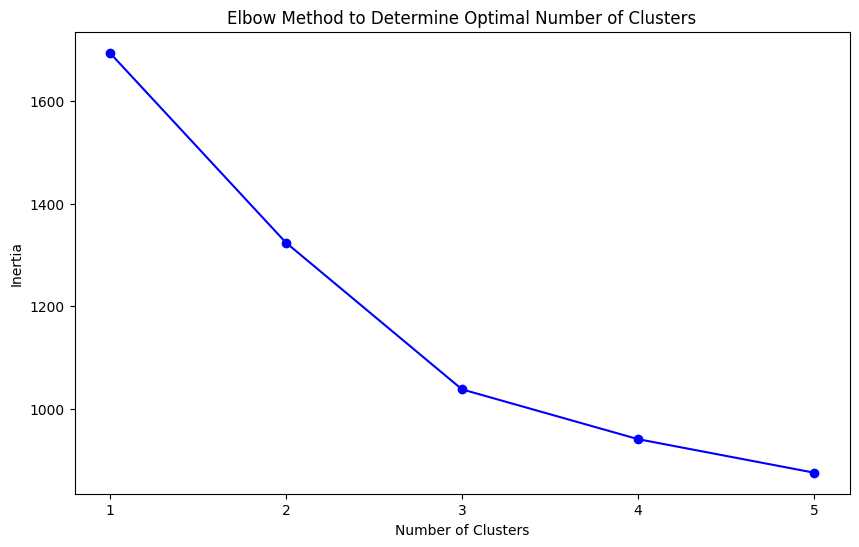

In [7]:
# step 1
features = [
    # attacking stats
    'Goals per match', 'Shots_PA', 'Shooting accuracy %',
    
    # defensive stats
    'Tackles_PA', 'Interceptions_PA', 
    'Recoveries_PA', 'Duels_won_PA', 'Tackle success %', 'Aerial_battles_won_PA',
    
    # playmaking stats
    'Assists_PA', 'Passes per match', 'Through_balls_PA', "Accurate_long_balls_PA",
    'Big_chances_PA'
]

X = df[features]


# step 2
# normalize data using sklearn StandardScaler, scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# step 3
# determine the best number of clusters using Inertia plot
inertia = []
K = range(1, 6)  # Try between 1 and 5 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xticks(K)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.show()

Based on the Inertia Graph, it seems 3 clusters is the optimal number of clusters to use for the K means algorithm, as that is where the elbow occurs.

Now we can fit our data through the K Means algorithm and assign each player to one of 3 clusters.

In [8]:
# cluster players using KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

We can use PCA to reduce our dimensions to a couple components and try to make it easier to visualize our clusters, since it will allow us to plot it in 2D space. This will allow us to see if there is cluster overlap and if there are outliers.

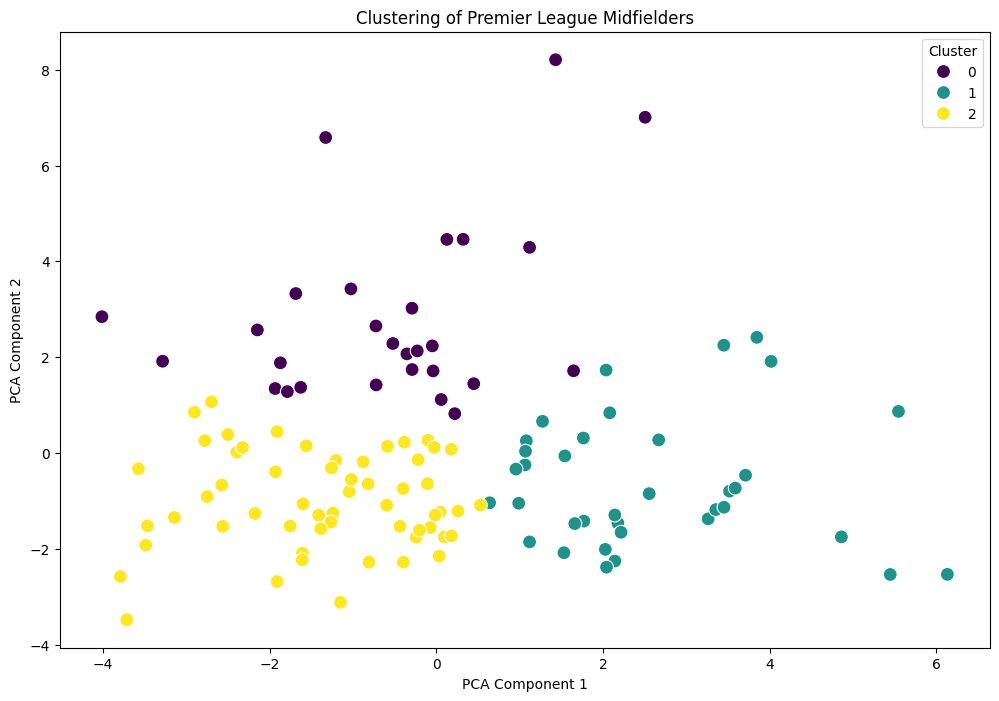

In [9]:
# PCA clusters plot

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=100)
plt.title('Clustering of Premier League Midfielders')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

We can see that the clusters are distinct and, therefore, our KMeans implementation has done a good job of grouping clusters.

## Analyzing Clustering Results

In [10]:
# Calculate the mean values for each cluster
cluster_means = df.groupby('Cluster')[features].mean()
cluster_means

,Goals per match,Shots_PA,Shooting accuracy %,Tackles_PA,Interceptions_PA,Recoveries_PA,Duels_won_PA,Tackle success %,Aerial_battles_won_PA,Assists_PA,Passes per match,Through_balls_PA,Accurate_long_balls_PA,Big_chances_PA
Cluster,,,,,,,,,,,,,,
0,0.191786,1.759807,35.928571,1.087936,0.428513,3.693579,3.616228,55.428571,0.426189,0.181847,32.329643,0.274549,1.230954,0.276034
1,0.078056,0.950454,28.277778,2.233566,1.141015,5.777055,5.272857,57.944444,1.118169,0.064101,43.803889,0.214254,2.109939,0.095573
2,0.055088,0.712065,30.280702,1.169006,0.534083,3.073965,2.983349,58.894737,0.530346,0.051492,23.680000,0.097939,0.881079,0.079703


Based on the above dataframe, it looks like cluster 1 is the more defensive minded group of players. However, let's visualize this to make it easier to see.

Note: if the cluster means are used directly, there are virtually no differences between groups because, as one can see above, even though there are differences between each cluster, the differences are not huge, making it difficult to visualize. Therefore, I had to calculate the z scores (or standard scores), relative to mean and standard deviation indicating how much each cluster's average deviates from the mean across all clusters. This made the differences much more noticeable in the plot.


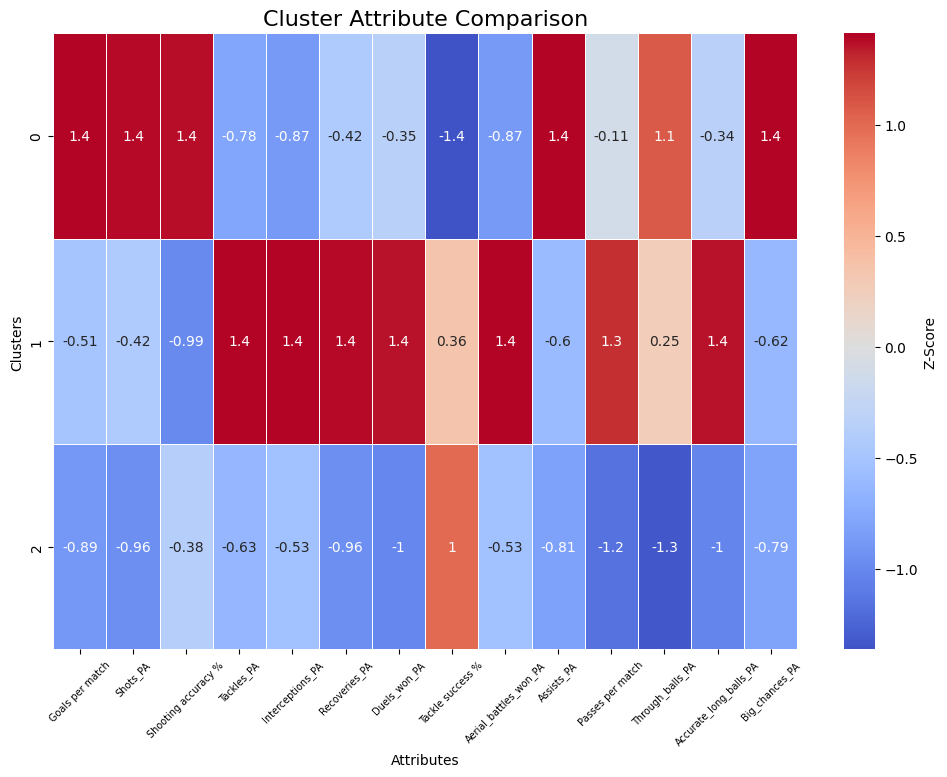

In [11]:
# Use z-score to better spot differences
z_cluster_means = cluster_means.apply(zscore, axis=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    z_cluster_means,
    annot=True,
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'Z-Score'},  # Color bar label
    linewidths=.5         # Line width between cells
)

plt.title('Cluster Attribute Comparison', fontsize=16)
plt.xlabel('Attributes')
plt.ylabel('Clusters')
plt.xticks(rotation=45, fontsize=7)
plt.show()


As we can see, cluster 1 is the cluster we are most interested in since they have the highest scores for almost all defensive statistics, the exception being tackle success rate which may be explained by the fact they attempt more tackles than other players. However, cluster 1's tackle success rate is still above average.

On the other hand, cluster 0 is clearly attacking midfielders, as they excel in goals, shots, shooting accuracy, assists, through balls, and creating big chances. I was surprised by the visualization for cluster 2, which can be interpreted as midfielders who, although they may not excel at one particular thing, perform well across the board, and also the stats used do not completely encapsulate what these players have to offer.

**TLDR**

- Cluster 0 for attacking midfielders
- Cluster 1 for defensive midfielders
- Cluster 2 for balanced/versatile midfielders

### Who are our defensive midfielder options?

In [12]:
df[df['Cluster'] == 1][['Player_Name']]

,Player_Name
1,Ryan Christie
6,Jefferson Lerma
8,Philip Billing
9,Lewis Cook
10,Douglas Luiz
11,John McGinn
14,Boubacar Kamara
16,Youri Tielemans
26,Mario Lemina
28,Moisés Caicedo


Given we are looking for a defensive midfielder for a small Premier League club, one important factor will be the market value of these players. It is fair to assume someone like Rodri would not fit into our budget, as it would be too expensive; I will assume a maximum of 35 million Euro for the defensive midfielder. I got market value data from the website Transfermarkt for all midfielders in the dataset.

Let's join that data:

In [13]:
# perform inner join since we have data for each player
df = df.merge(pd.read_csv('data/notebook/Prem_player_values.csv'))

Now let's see who our remaining options are once we apply a market value filter under 35M, sorted by ascending market value:

In [14]:
potential_signings = df[(df['Cluster'] == 1) & (df['Market Value (M Euro)'] < 35)].sort_values('Market Value (M Euro)')

potential_signings

,Player_Name,Appearances,Goals,Goals per match,Headed goals,Goals with right foot,Goals with left foot,Penalties scored,Freekicks scored,Shots,...,Tackles_PA,Interceptions_PA,Big_chances_PA,Recoveries_PA,Duels_won_PA,Through_balls_PA,Accurate_long_balls_PA,Aerial_battles_won_PA,Cluster,Market Value (M Euro)
80,Idrissa Gueye,195,7,0.04,0,6,1,0,1,141,...,3.697436,2.292308,0.025641,8.133333,6.851282,0.066667,2.220513,0.892308,1,3.0
26,Mario Lemina,131,7,0.05,3,4,0,0,0,125,...,2.335878,1.312977,0.053435,5.198473,5.114504,0.152672,1.709924,1.000000,1,10.0
91,Abdoulaye Doucouré,248,33,0.13,6,22,4,0,0,303,...,1.745968,0.947581,0.108871,6.701613,4.076613,0.060484,1.205645,1.072581,1,10.0
1,Ryan Christie,72,1,0.01,0,0,1,0,0,76,...,1.694444,1.083333,0.152778,5.319444,4.638889,0.319444,1.569444,0.541667,1,12.0
9,Lewis Cook,139,1,0.01,1,0,0,0,0,55,...,1.611511,1.151079,0.057554,5.568345,3.525180,0.107914,2.021583,0.611511,1,12.0
116,Jorginho,181,21,0.12,0,21,0,19,0,76,...,1.917127,1.353591,0.127072,6.259669,3.723757,0.408840,2.563536,0.453039,1,12.0
38,Wilfred Ndidi,195,7,0.04,1,4,2,0,0,193,...,3.594872,2.005128,0.035897,8.000000,7.661538,0.097436,1.958974,2.646154,1,16.0
106,Christian Nørgaard,91,6,0.07,3,2,1,0,0,85,...,2.758242,1.725275,0.197802,7.307692,5.274725,0.175824,1.857143,1.208791,1,18.0
113,Thomas Partey,98,6,0.06,1,4,0,0,0,109,...,1.806122,0.928571,0.040816,5.979592,4.520408,0.265306,2.795918,0.938776,1,18.0
29,Pierre-Emile Højbjerg,254,12,0.05,0,10,2,0,0,240,...,1.984252,1.338583,0.078740,7.342520,4.893701,0.165354,3.086614,0.984252,1,18.0


We can also create a defensive, playmaking, and attacking score using z scores based on our selected stats to try to make it easier to identify where each of our options excel:

In [15]:
potential_signings = potential_signings.copy()

defensive_stats = ['Tackles_PA', 'Interceptions_PA', 'Recoveries_PA', 'Duels_won_PA', 'Tackle success %', 'Aerial_battles_won_PA',]
playmaking_stats = ['Assists_PA', 'Passes per match', 'Through_balls_PA', "Accurate_long_balls_PA", 'Big_chances_PA']
attacking_stats = ['Goals per match', 'Shots_PA', 'Shooting accuracy %']

potential_signings['Defensive Score'] = potential_signings[defensive_stats].apply(zscore, axis=0).sum(axis=1)
potential_signings['Playmaking Score'] = potential_signings[playmaking_stats].apply(zscore, axis=0).sum(axis=1)
potential_signings['Attacking Score'] = potential_signings[attacking_stats].apply(zscore, axis=0).sum(axis=1)

potential_signings[['Player_Name', 'Defensive Score', 'Playmaking Score', 'Attacking Score', 'Market Value (M Euro)']].sort_values('Market Value (M Euro)')

,Player_Name,Defensive Score,Playmaking Score,Attacking Score,Market Value (M Euro)
80,Idrissa Gueye,10.126465,-2.296606,-2.169987,3.0
26,Mario Lemina,0.581949,-2.843962,-0.914934,10.0
91,Abdoulaye Doucouré,-1.774478,-1.486624,3.003480,10.0
1,Ryan Christie,-3.678653,0.346720,-0.998408,12.0
9,Lewis Cook,-3.653273,-1.996795,-4.857559,12.0
116,Jorginho,-3.135300,4.801070,1.113751,12.0
38,Wilfred Ndidi,10.080847,-1.669298,-2.379313,16.0
106,Christian Nørgaard,2.746254,2.358199,0.230144,18.0
113,Thomas Partey,-2.042680,1.016401,-1.151782,18.0
29,Pierre-Emile Højbjerg,0.863793,2.891882,-0.342090,18.0


These are the final options we could consider for our new signing, sorted from least expensive to most expensive. Some limitations or aspects to improve upon this analysis:

1. Not taking the teams they play/have played in into consideration
    
    Each team has a unique style of play and this can greatly affect the roles (and therefore the stats and type of defensive midfielder) of players. As a simple example, some teams press high and like to have long possessions of the ball while others may prefer to cede the initiative to the opposing team and prioritize defending and hurting the opposition on the counter-attack.

2. Age
    
    Age is an important factor when making signings on the transfer market. Typically, young players will have higher market values than old players, as old players approach retirement. Not only do players deteriorate physically as they age, signing a younger player also means you potentially have a new midfielder for years to come.


## Next steps

It would be nice if coaches and people in charge of making transfer decisions had a more visually appealing way of presenting these results. As such, I will now create a dashboard to display our insights and make the decision making process easier.

In [16]:
# replace cluster values with cluster names
df['Cluster'] = df['Cluster'].replace({0:"Attacking", 1:"Defensive", 2:"Balanced"})

In [17]:
# Save normalized cluster avgs
df.groupby('Cluster')[features].mean().apply(zscore, axis=0).reset_index().to_csv('data/dash/Cluster_avg.csv', index=False)

In [23]:
# save player normalized stats
player_stats = df[features].apply(zscore, axis=0)
player_stats = df[['Player_Name', 'Market Value (M Euro)', 'Cluster']].join(player_stats)

player_stats.to_csv('data/dash/Normalized_player_stats.csv', index=False)


In [24]:
# one of the players is now retired, so his market value is null
print(df.isnull().sum().sum())

# we can remove him from our dataset to be used in the dashboard since he is no longer available
df.dropna(inplace=True)
df.to_csv("data/dash/Clustered_player_stats.csv", index=False)

1
